Import Python Libraries

In [1]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
import scipy.io as sio
import xarray as xr
import matplotlib.dates as mdates
from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

### Prepare Data

Read the data.

In [2]:
filename_pattern  = '/home/voyager-sbarc/arc/sst/hadisst/HadISST_sst.nc'
ds = xr.open_dataset(filename_pattern)
ds

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 360, nv: 2, time: 1787)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2018-11-16T12:00:00
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    14/1/2019 converted to netcdf from pp format
    supplementary_information:  Updates and sup

Crop the data to 30S-30N.

In [3]:
ds_subset = ds.sel(latitude=slice(30,-30))
ds_subset

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 360, nv: 2, time: 1787)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2018-11-16T12:00:00
  * latitude   (latitude) float32 29.5 28.5 27.5 26.5 ... -27.5 -28.5 -29.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    14/1/2019 converted to netcdf from pp format
    supplementary_information:  Updates and supp

Compute the annual cycle of SST fitting the first and second harmonics.

In [4]:
climatology = ds_subset.groupby('time.month').mean('time')
climatology

/home/nash/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 360, month: 12, nv: 2)
Coordinates:
  * latitude   (latitude) float32 29.5 28.5 27.5 26.5 ... -27.5 -28.5 -29.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    time_bnds  (month, nv) float32 27027.584 27058.584 ... 27179.203 27210.203
    sst        (month, latitude, longitude) float32 19.316332 ... 21.992668

Create 1st two harmonics and add together

In [5]:
def fourier(ds,p):
    time = ds.month
    n = len(time) 
 
    ds,time = xr.broadcast(ds,time)

    f = 2.*np.pi*p/n
    ft = f*time

    sum_a = ds*np.cos(ft - 1.)
    sum_b = ds*np.sin(ft - 1.)
    coef_a = (2./n)*sum_a.sum('month',skipna=True)
    coef_b = (2./n)*sum_b.sum('month',skipna=True)

    return ft,coef_a, coef_b

def harmonic(ds):
    a0 = ds.mean('month',skipna=True)

    #-First Harmonic
    p     = 1
    ft,coef_a,coef_b = fourier(ds,p)
    harm1 = a0 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    #-Second Harmonic
    p     = 2
    ft,coef_a,coef_b = fourier(ds,p)
    harm2 = a0 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    #-First plus second
    combo = harm1 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    return combo

In [6]:
annual_cycle = harmonic(climatology)
annual_cycle

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 360, month: 12, nv: 2)
Coordinates:
  * latitude   (latitude) float32 29.5 28.5 27.5 26.5 ... -27.5 -28.5 -29.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    time_bnds  (nv, latitude, longitude, month) float64 2.708e+04 ... 2.721e+04
    sst        (latitude, longitude, nv, month) float64 19.37 18.39 ... 21.99

Remove the annual cycle from the monthly SST in each gridpoint

In [7]:
anomalies = ds_subset.groupby('time.month') - annual_cycle
anomalies.sst.shape

(1787, 60, 360, 2)

Remove the long-term mean in each gridpoint - already done via harmonics

In [8]:
long_term_mean = anomalies.sst[:,:,:,0].mean('time')
print(long_term_mean.shape)

sst = anomalies.sst[:,:,:,0] - long_term_mean

/home/nash/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(60, 360)


Weight the SST anomaly value in each gridpoint by the square of the cosine of the latitude

In [9]:
# Weight the data set according to weighting argument.
coslat = np.cos(np.deg2rad(sst.coords['latitude'].values))
wgts = np.sqrt(coslat)
wgts = xr.DataArray(wgts, coords=[sst.latitude], dims=['latitude'])
sst,weights = xr.broadcast(sst,wgts)
weighted_data = sst * weights
print(weighted_data.shape)

(1787, 60, 360)


### EOF Analysis

In [10]:
sst = anomalies.sst[:,:,:,0]

# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

## Set center to True to remove long-term mean
solver = Eof(sst, weights=wgts, center=True)


#### 1a. Compute the eigenvalues and eigenvectors of the covariance matrix.

In [11]:
# Retrieve the eigenvalues
eig = solver.eigenvalues(neigs=20)
eig

<xarray.DataArray 'eigenvalues' (mode: 20)>
array([1267.718713,  641.208869,  188.275406,  136.923242,  128.254058,
        112.036181,   94.2718  ,   78.147116,   68.057048,   64.658489,
         59.197266,   53.776124,   50.017248,   47.948128,   44.145098,
         39.627534,   34.817252,   31.759533,   30.209169,   29.135798])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Attributes:
    long_name:  eigenvalues

#### 1b. Plot the percentage of explained variance for eigenvalues 1-20.

Text(0, 0.5, 'Variance Explained (%)')

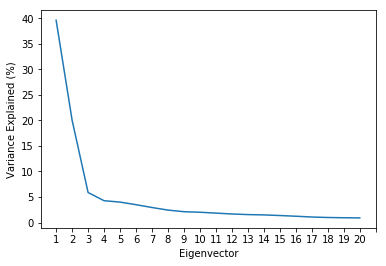

In [12]:
var_eig = eig/sum(eig)*100;
plt.plot(var_eig)
plt.xticks(np.arange(0,21,1), labels=np.arange(1,21,1))
plt.xlabel('Eigenvector')
plt.ylabel('Variance Explained (%)')

#### 1e. Plot the EOF patterns and PCs for the first 5 modes. 

In [13]:
# Retrieve the leading EOF and PCS.
eof1 = solver.eofs(neofs=5)
pc1 = solver.pcs(npcs=5, pcscaling=1)

./results/EOF_ENSO_eofs.png


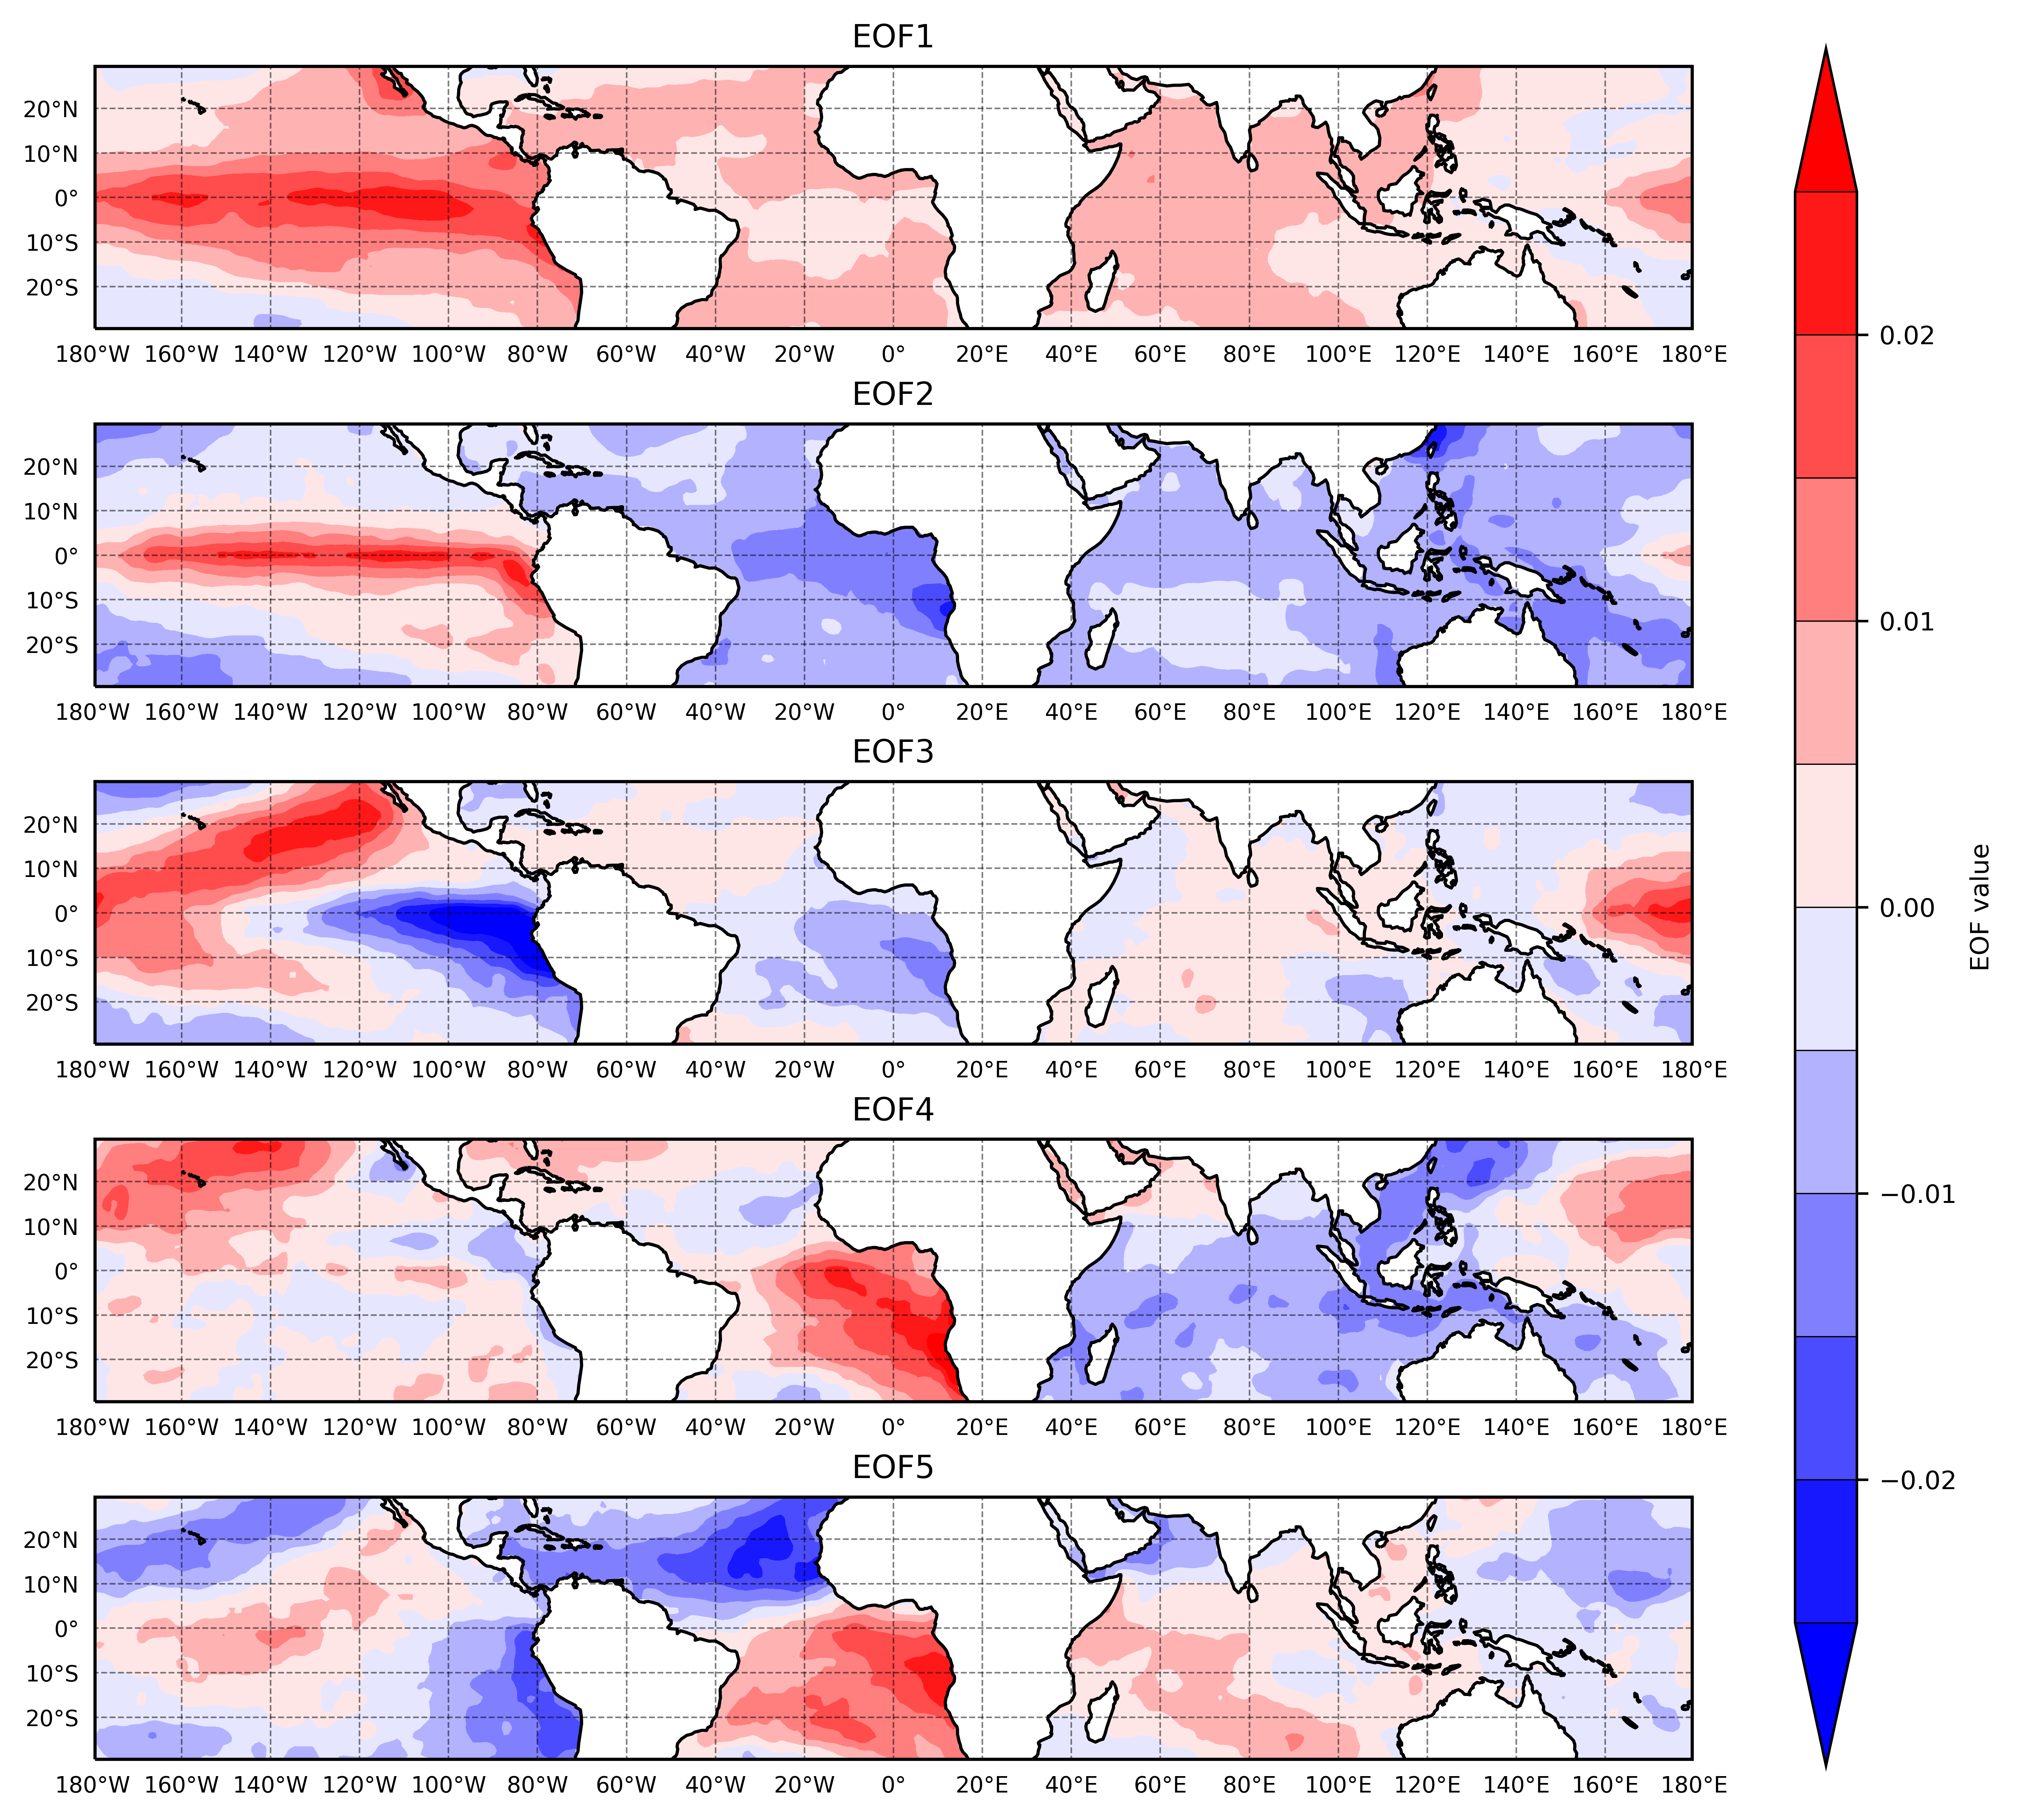

<Figure size 5400x6000 with 0 Axes>

In [14]:
fig = plt.figure(figsize=(9,10))
fig.dpi = 600
fname = './results/EOF_ENSO_eofs'
fmt = 'png'
results = eof1
subtitles = ['EOF1', 'EOF2', 'EOF3', 'EOF4', 'EOF5']

lats = eof1['latitude']
lons = eof1['longitude']

clevs = np.arange(-0.025, 0.030, 0.005)

for i in np.arange(len(results)):
    ax = plt.subplot(5, 1, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
    cf = ax.contourf(lons, lats, results[i], transform=ccrs.PlateCarree(),
                     extend='both', cmap='bwr', levels=clevs)
    ax.coastlines(linewidths=1.0)
    ax.set_title(subtitles[i], fontsize=10)
    ## Add in meridian and parallels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 200, 20))
    gl.ylocator = mticker.FixedLocator(np.arange(-30, 40, 10))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.95, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('EOF value', fontsize=8)

plt.subplots_adjust(hspace=0.2, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

./results/PCA_ENSO_eofs.png


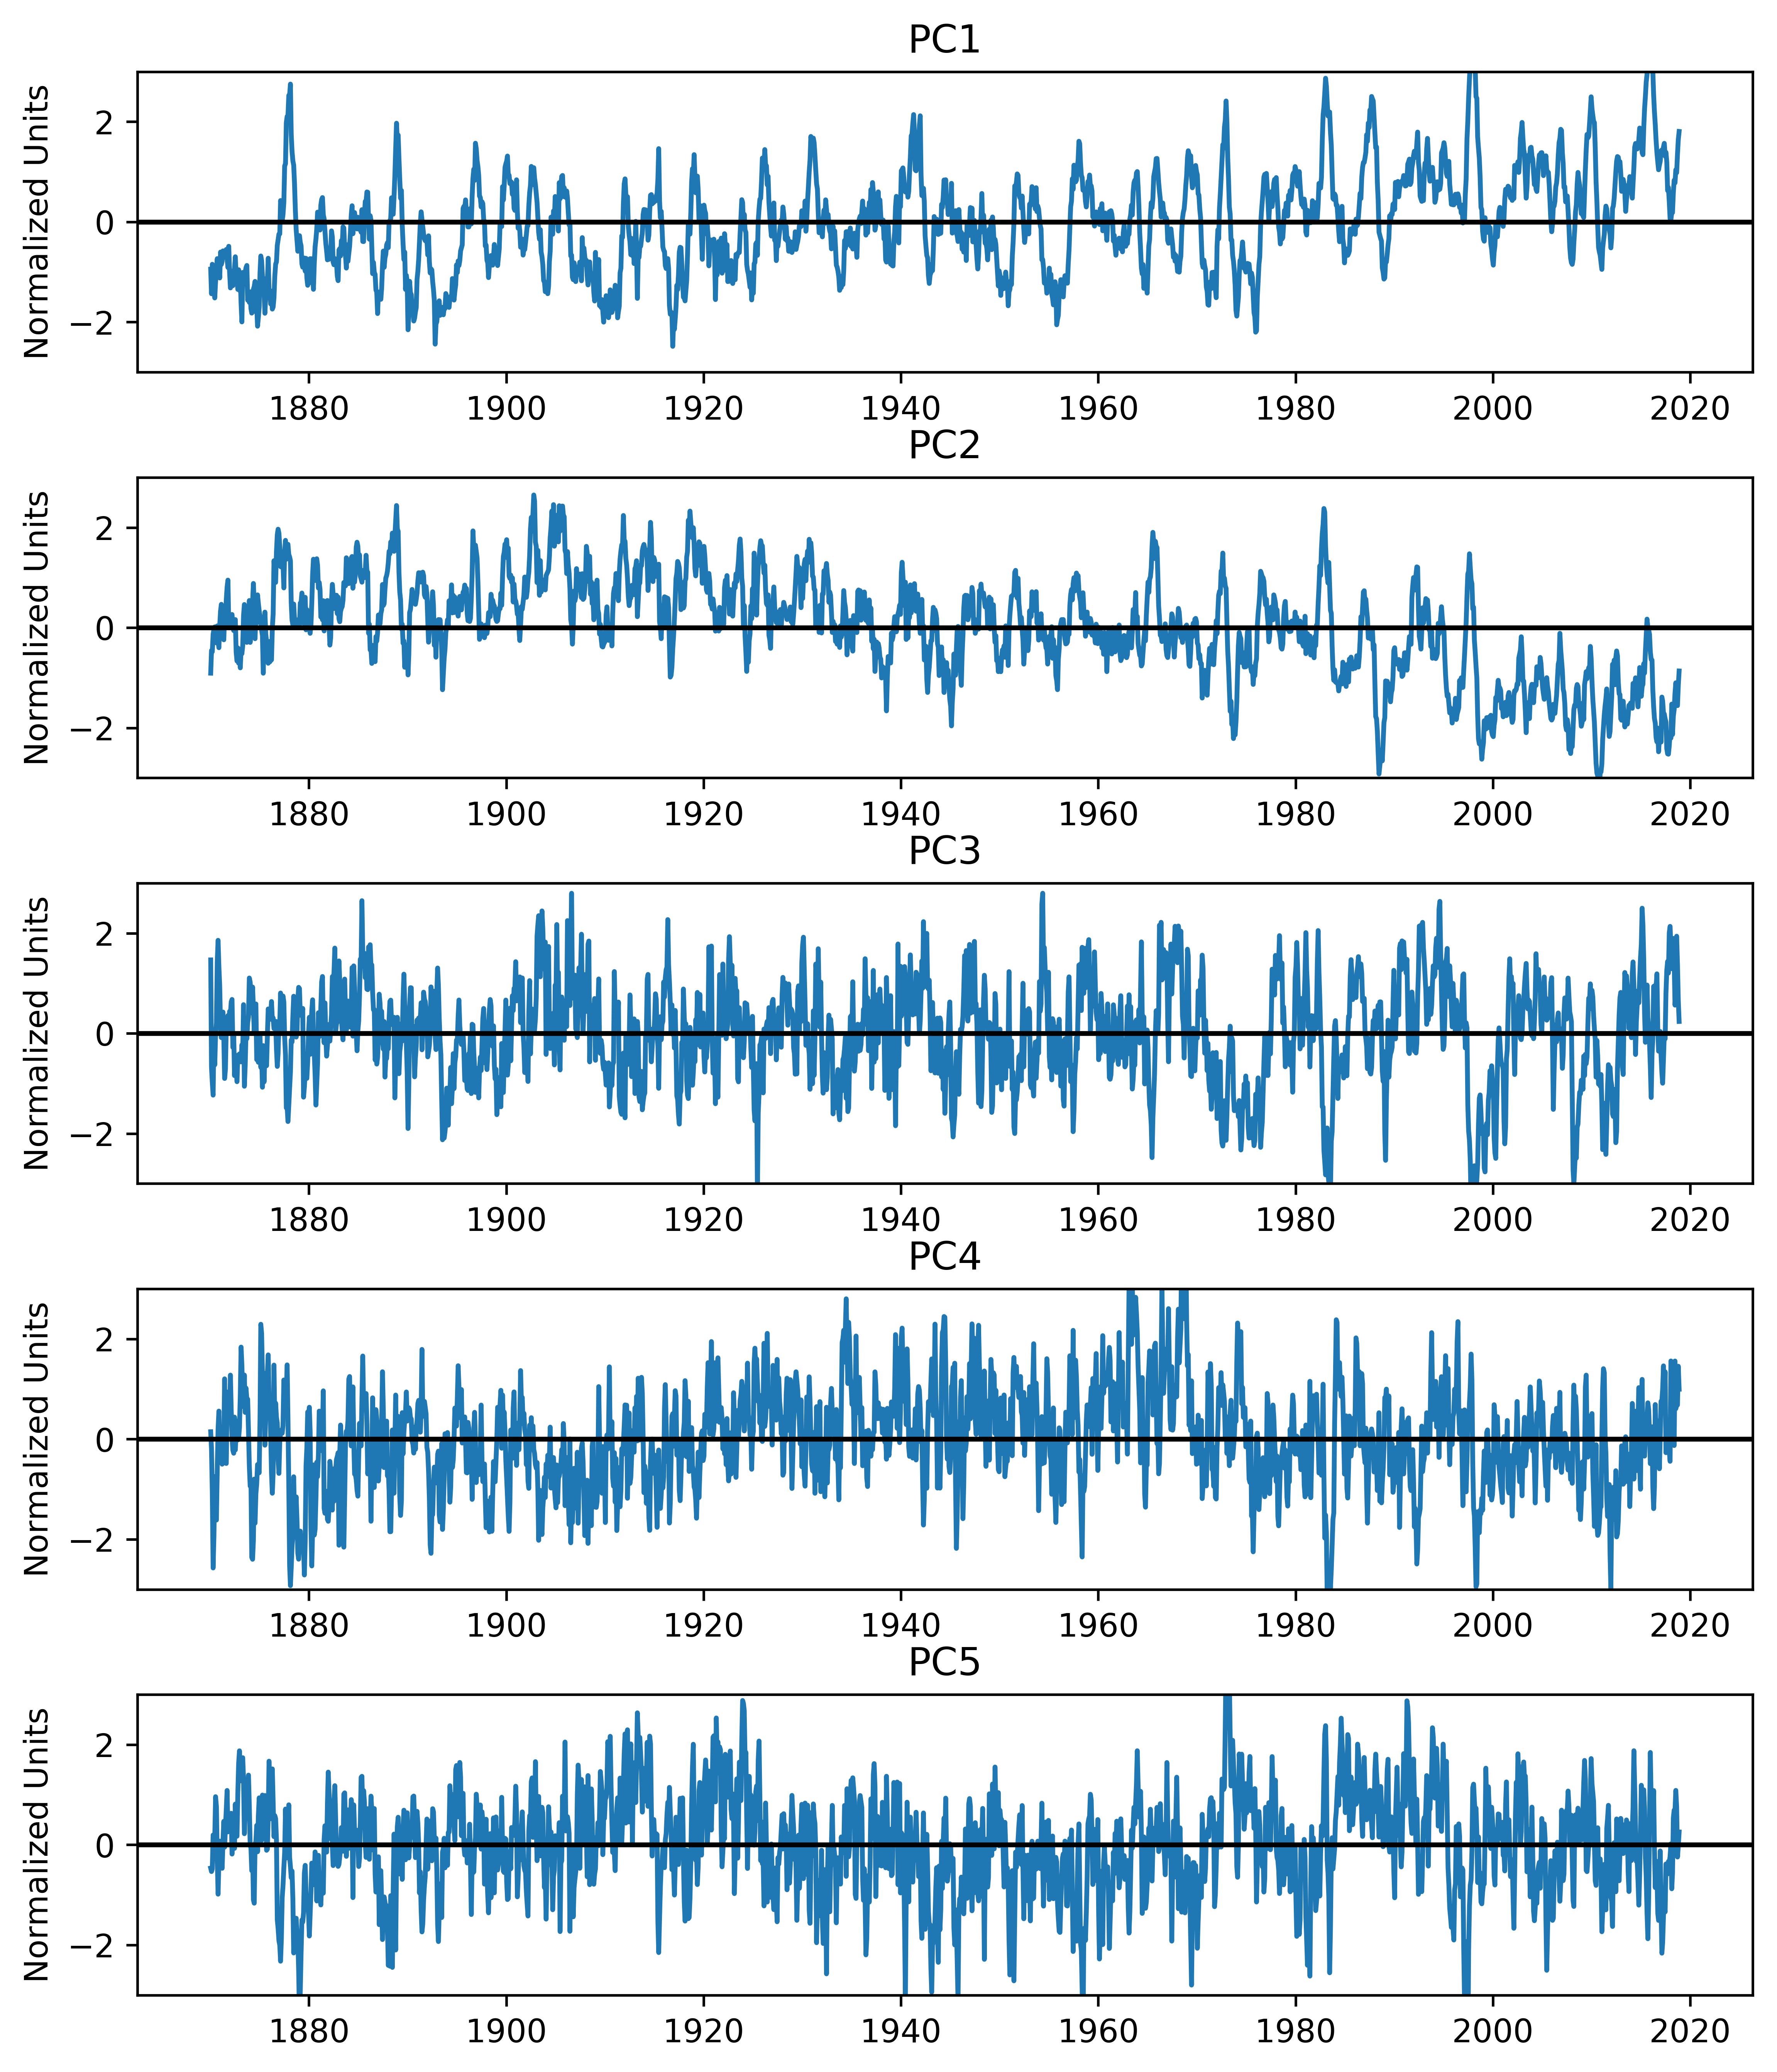

<Figure size 5400x6600 with 0 Axes>

In [15]:
fig = plt.figure(figsize=(9,11))
fig.dpi = 600
fname = './results/PCA_ENSO_eofs'
fmt = 'png'
results = pc1
subtitles = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']

X, nplots = pc1.shape

for i in np.arange(nplots):
    ax = plt.subplot(5, 1, i+1)
    ax.plot_date(pc1.time, pc1[:,i], '-')
    ax.axhline(0, color='k')
    ax.set_ylim(-3, 3)
    ax.set_ylabel('Normalized Units')
    ax.set_title(subtitles[i], fontsize=12)

plt.subplots_adjust(hspace=0.35, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

### EOF Separation

#### 2a. Using SST anomalies, compute the first auto-correlation for each gridpoint and obtain an average value. Estimate the effective sample size using:

$$ n' \equiv \frac{1 - \rho_{1}}{1 + \rho_{1}}$$

In [56]:
numtimes, numlats, numlons = weighted_data.shape
X1 = np.reshape(weighted_data[:-1, :,:].values, [numtimes-1, numlats*numlons])
X2 = np.reshape(weighted_data[1:, :,:].values, [numtimes-1, numlats*numlons])
X1.shape

autocorr1 = []
for i in np.arange(numlats*numlons):
    autocorr1.append(np.corrcoef(X1[:,i], X2[:,i]))


In [68]:
autocorr1_array = np.array(autocorr1)
autocorr1_mean = np.nanmean(autocorr1_array[:, 1, 0])

sample_size = numtimes*((1-autocorr1_mean)/(1+autocorr1_mean))
print(sample_size)

250.35980272653308


In [88]:
autocorr1_mean

0.754231135421947

#### 2b. Use the North et al (1982) criteria to estimate the uncertainty in the eigenvalues estimation.

In [81]:
factor = np.sqrt(2.0 / sample_size)
errors = eig * factor
errors

<xarray.DataArray 'eigenvalues' (mode: 20)>
array([113.306702,  57.310239,  16.827759,  12.237984,  11.463146,  10.013617,
         8.425865,   6.984666,   6.082832,   5.779074,   5.290958,   4.806425,
         4.470463,   4.285528,   3.945619,   3.541847,   3.111911,   2.838617,
         2.700048,   2.604112])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

#### 2c. Plot eigenvalues 1-20 with the error bars calculated in item 2b above.

([<matplotlib.axis.XTick at 0x2b6548a65ac8>,
 <a list of 20 Text xticklabel objects>)

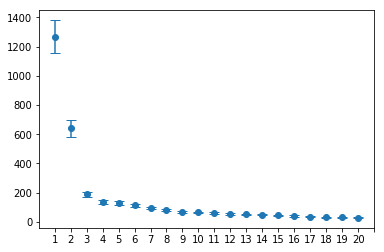

In [86]:
plt.errorbar(x=np.arange(0,20,1), y=eig, yerr=errors, fmt='o', capsize=5)
plt.xticks(np.arange(0,21,1), labels=np.arange(1,21,1))

 ### Questions

1.	Why do you need to weight the SST values by the square of cosine of latitude?
2.	How many EOF modes are separated?
3.	Please give an interpretation for EOFs 1-5

EOF 1 is showing positive loading in the southern Pacific, close to the region where the ENSO signal appears. 
